In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import scipy as sp
import os,csv
import statsmodels.api as sm
from scipy import interpolate

# === Matplotlib ===
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

# === Plot size ===
WIDTH = 5
rcParams['figure.figsize'] = WIDTH, WIDTH
rcParams['figure.dpi'] = 300

# === Color map ====
rcParams['image.cmap'] = 'gray'
rcParams['image.interpolation'] = 'none'

# === Axes Style ===
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 22
rcParams['axes.labelweight'] = 'normal'
#rcParams['axes.facecolor'] = 'f2f2f2'
rcParams['axes.edgecolor'] = '444444' # GREY
rcParams['axes.axisbelow'] = True
rcParams['axes.labelcolor'] = '444444' # GREY

# === Font Style ===
rcParams['font.size'] = 15

# === Legend Style ===
rcParams['legend.fontsize'] = 'medium'
rcParams['legend.frameon'] = True
rcParams['legend.numpoints'] = 3

# === Tick Style ===
rcParams['xtick.major.pad'] = 4
rcParams['xtick.major.width'] = 1
rcParams['xtick.color'] = '444444' # GREY

rcParams['ytick.major.pad'] = 5
rcParams['ytick.major.width'] = 1
rcParams['ytick.color'] = '444444' # GREY

rcParams['lines.linewidth'] = 2

# === Grid Style ===
rcParams['axes.grid'] = False
rcParams['grid.linestyle'] = '--'
rcParams['grid.alpha'] = .25
rcParams['grid.color'] = '444444'
rcParams['grid.linewidth'] = 2


color_wheel = ['#332288', # blue
'#CC6677', # red
'#117733', # green
'#88CCEE', # light blue
'#44AA99',
'#999933',
'#882255',
'#DDCC77',
'#AA4499']
# == Colors ===
rcParams['axes.prop_cycle'] = plt.cycler('color', color_wheel)

pd.set_option('display.max_columns', 100)

In [2]:
k = 1.9872041E-3  # kcal/mol/K
rho = 0.03332819694513222
el_chg = 1.60217662e-19 #coulomb
Na = 6.02214129e23
epsilon0 =  8.854187817e-12  #F/m
eps0 = 5.5268e-2  # e/V/nm
kcal_eV = 2.611448e22  # kcal/(eV)

# Functions

In [3]:
def find_array_minimum_point(z_coord, array, z_min, z_max):
    from scipy import interpolate
    midpoint = 0.5*(z_min+z_max)
    array_itp = interpolate.interp1d(z_coord, array, kind='linear')
    fun = lambda closest_to_0 : abs(array_itp(closest_to_0)[0])
    bounds = [(z_min, z_max)]
    x = sp.optimize.minimize(fun, midpoint, bounds=bounds)
    #print x
    return x.x[0]


def lpot_rpot(z_coord, pot, z_mid1=4, z_mid2=6, z_end=10, field=None):
    """ If field is provided, defines midpoint as a place where field is closest to 0"""
    if np.any(field):
        smallest_field = find_array_minimum_point(field[:,0], field[:,1], z_mid1, z_mid2)
        mid_pot = np.mean(pot[z_coord <= smallest_field])
    else:
        mask = (z_coord > z_mid1) & (z_coord < z_mid2)
        mid_pot = np.mean(pot[mask])
    end_pot = np.mean(pot[z_coord > z_end])
    return mid_pot, end_pot - mid_pot

def num_derivC(pot, chg):
    """ Central difference numerical deriv using numpy."""
    dchg = np.gradient(chg)
    dpot = np.gradient(pot)
    return dchg/dpot

# Smoothing functions

from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    """http://stackoverflow.com/questions/28536191/how-to-filter-smooth-with-scipy-numpy"""
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def smooth(x,window_len=11,window='hanning'):
    """http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html"""
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    """
    import numpy as np
    from math import factorial
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')


# Load potentials

In [37]:
surf_chgs = ['0.00', '2.00',  '4.00', '6.00',  '8.00', '10.00',
             '12.00', '16.00', '20.00', '24.00', '28.00', '32.00']

# surf_chgs = ['0.00',  '4.00', '8.00',
#              '12.00', '16.00', '20.00', '24.00', '28.00', '32.00', '36.00', '40.00',
#              '60.00', ]
#gold_path = '../julia_sim/AuEMImBF4/Experiments/Au/EMImBF4/450/a/'
# surf_chgs = [dirs for dirs in os.listdir(gold_path) 
#              if os.path.isdir(os.path.join(gold_path, dirs))]
surf_chgs = sorted(surf_chgs, key=float)

potentials   = []
pot_name = 'potential_mod.xvg'
field_name = 'field_mod.xvg'
generic_data_path = '../vlad_simulations/EMImBF4/450/a/{surf_chg}/{replica}'
#generic_data_path = gold_path + '{surf_chg}/{replica}/'

for surf_chg in surf_chgs:
    chg_pots = []
    for replica in ['0',]:
        try:
            #print 'Analyzing chg: {}, replica {}'.format(surf_chg, replica)
            p = os.path.join(generic_data_path.format(surf_chg=surf_chg, replica=replica), pot_name)
            pot = np.loadtxt(p, comments=['#','@'])
            p = os.path.join(generic_data_path.format(surf_chg=surf_chg, replica=replica), field_name)
            field = np.loadtxt(p, comments=['#','@'])
            z = field[:,0]
#             plt.plot(z, pot[:,1])
#             plt.show()
            z_dist = z[-1]
            z_min = z_dist/2.0 - 1
            z_max = z_dist/2.0 + 1
            lr_pots = lpot_rpot(pot[:,0], pot[:,1], field=field, z_mid1=z_min, z_mid2=z_max, z_end=z_dist-.05)
        except IOError:
            print surf_chg, replica, 'is missing'
            lr_pots = [np.NaN, np.NaN]
        chg_pots.append(lr_pots)
    potentials.append(chg_pots)
potentials = np.array(potentials)

In [38]:
# Keep all potentials
# chgs = np.array(surf_chgs, dtype=float)
# chgs = np.hstack([-chgs[::-1], chgs])
# chgs = np.c_[chgs,chgs,chgs]
# chgs_replicas = chgs.copy()
# chgs = chgs.flatten()
# potentials_replicas = potentials.copy()
# potentials_replicas = np.vstack([np.flipud(potentials_replicas[:,:,1]), -potentials_replicas[:,:,0]])
# num_of_potentials = len(chgs)/2
# potentials = potentials.reshape(num_of_potentials,2)
# potentials = np.hstack([potentials[:,1][::-1], -potentials[:,0]])
# # average 0
# #potentials[chgs==0.0] = np.mean(potentials[chgs==0.0])
# gromacs_data = np.c_[potentials, chgs]

# Average out replicas
chgs = np.array(surf_chgs, dtype=float)
chgs = np.hstack([-chgs[::-1], chgs])
averaged_potentials = np.mean(potentials,axis=1)
averaged_potentials = np.hstack([averaged_potentials[:,1][::-1], -averaged_potentials[:,0]])
gromacs_data = np.c_[averaged_potentials, chgs]

# Capacitance calculations

### Smoothing pot/chg

(24, 2)
(22, 2)


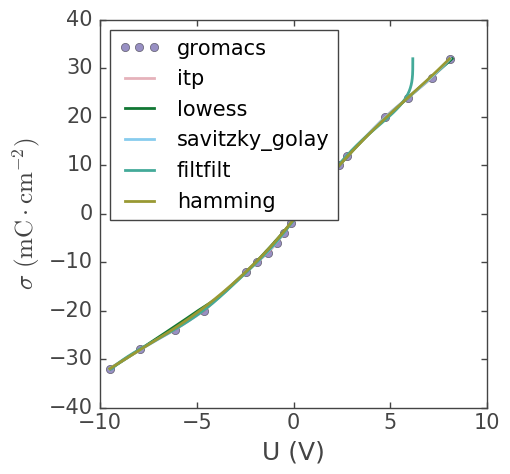

In [40]:
# remove outlier
print gromacs_data.shape
gromacs_data =np.vstack((gromacs_data[:4,:], gromacs_data[5:-5,:], gromacs_data[-4:, :]))

print gromacs_data.shape


pot, chg = gromacs_data[:,0], gromacs_data[:,1]
plt.plot(pot, chg,'o', label='gromacs', alpha=.5)

# interpolate to increase point size
# and regularize grid
chg_itp = np.linspace(chg.min(),chg.max(), 1000)
pot_itp = interpolate.interp1d(chg,pot, kind='linear')
pot_itp = pot_itp(chg_itp)
plt.plot(pot_itp, chg_itp , label='itp', alpha=.5)


# smooth using Locally Weighted Scatterplot Smoothing
# averages points in regions, it and frac are parameters that can 
# be varied if needed.
from statsmodels.nonparametric.smoothers_lowess import lowess
it=3   # doesn't seem to do much
frac=.3 # fraction of data used for each y
#lowess_chg = lowess(chg, pot, frac=frac, it=it, return_sorted=False)
lowess_pot = lowess(pot_itp, chg_itp, frac=frac, it=it, return_sorted=False)
plt.plot(lowess_pot, chg_itp, '-', label='lowess')

# smooth using moving average
from scipy.signal import savgol_filter
window_size, poly_order = 101, 1
sg_pot = savitzky_golay(pot_itp, window_size, poly_order)
plt.plot(sg_pot, chg_itp, label='savitzky_golay')

# filtfilt (high-pass filter), applied in two directions
cutoff = 20
fs = 5000
filtfilt_pot = butter_lowpass_filtfilt(pot_itp, cutoff, fs)
plt.plot(filtfilt_pot, chg_itp, '-', label='filtfilt')

# # pchip interpolation
# pchip_pot = sp.interpolate.pchip_interpolate(chg, pot, chg_itp)
# plt.plot(pchip_pot, chg_itp, '-', label='pchip')


# convolution
windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
ws=341
w = windows[2]
# longer extrapolation
dchg = chg_itp[1]-chg_itp[0]
chg_itp_long = np.arange(-200,200,dchg)
# do extrapolation
pot_itp_long_f = sp.interpolate.InterpolatedUnivariateSpline(chg_itp, pot_itp, k=1)
pot_itp_long = pot_itp_long_f(chg_itp_long)
llimit = (ws-1)/2
rlimit = ws-1 - llimit
conv_pot = smooth(pot_itp_long, window_len=ws, window=w)[llimit:-rlimit]
# go back to normal
conv_pot = conv_pot[(chg_itp_long > chg_itp[0]-dchg/2.0) & (chg_itp_long < chg_itp[-1]+dchg/2.0)]
plt.plot(conv_pot,chg_itp,  '-', label=w)


plt.xlabel('U (V)')
plt.ylabel(r'$\sigma$ $(\mathrm{mC\cdot cm^{-2}})$')
#plt.xlim(4,10)
#plt.ylim(15,40)
plt.legend(loc='best')

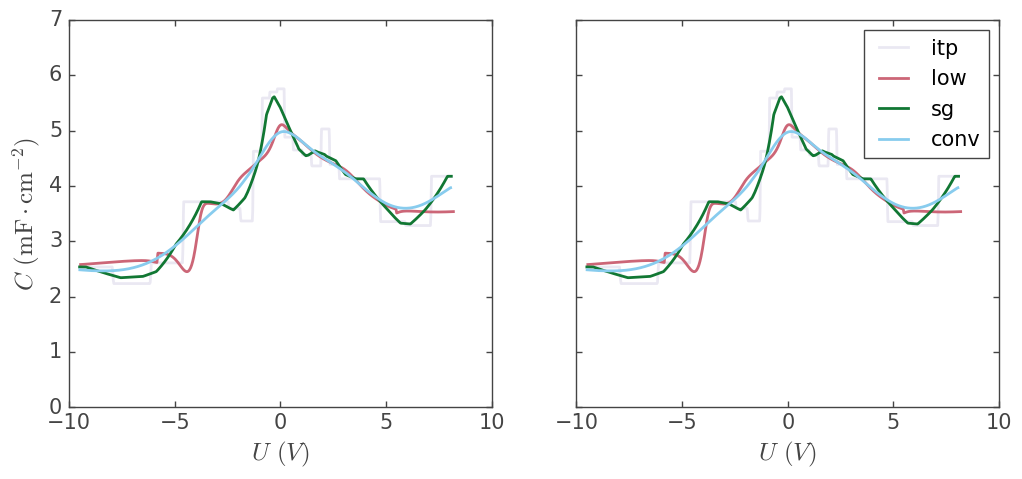

In [41]:
# Numerical derivative


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
for name, m_pot in zip(['itp', 'low', 'sg', 'conv'],
                        [pot_itp, lowess_pot, sg_pot,  conv_pot]):
    deriv = num_derivC(m_pot, chg_itp)
    alpha=1.0
    if name=='itp': alpha=.1
    ax1.plot(m_pot, deriv, '-', alpha=alpha, label=name)
    ax2.plot(m_pot, deriv, '-', alpha=alpha, label=name)
    #fig.show()
    
ax1.set_xlim(-10,10)
ax1.set_ylim(0,7)
#ax2.set_xlim(-25,15)
#ax1.legend(loc='best')
ax2.legend(loc='best')
ax1.set_xlabel('$U$ $(V)$')
ax2.set_xlabel('$U$ $(V)$')
ax1.set_ylabel(r'$C$ $(\mathrm{mF\cdot cm^{-2}})$')

In [44]:
chg_pot_cap = np.c_[chg_itp, conv_pot, num_derivC(conv_pot, chg_itp)]

np.savetxt('../data/chg_pot_cap_450_npt.txt', chg_pot_cap)

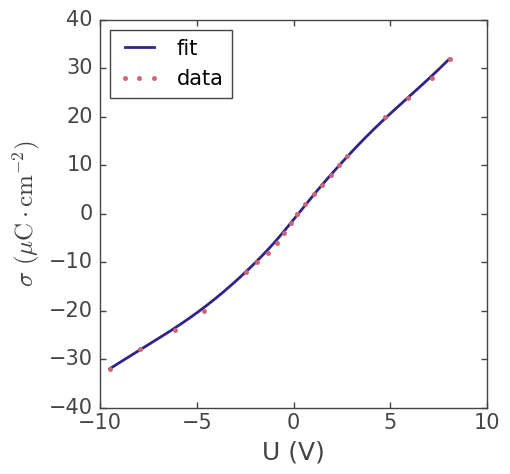

In [45]:
plt.plot(conv_pot,chg_itp,  label='fit')
plt.plot(pot,chg, '.', label='data')
plt.legend(loc='best')
plt.xlabel('U (V)')
plt.ylabel(r'$\sigma$ $(\mathrm{\mu C\cdot cm^{-2}})$')
mask = (chg_itp >= 42.00) & (chg_itp <= 58.00)
mask2 = (chg_itp <= -42.00) & (chg_itp >= -58.00)
plt.plot(conv_pot[mask2], chg_itp[mask2], '--',color='r', lw=3)
#plt.savefig('../gfx/u_sigma.png',dpi=300)

Capacitance maximum: 4.98334358707
Corresponding charge: -0.416416416416
Corresponding potential: 0.153915660305


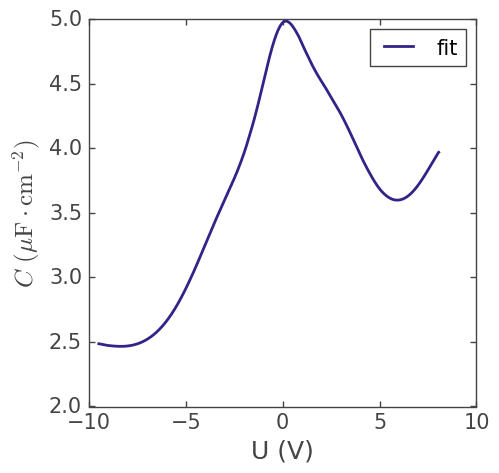

In [46]:
plt.plot(conv_pot,chg_pot_cap[:,2],  label='fit')
plt.legend(loc='best')
plt.xlabel('U (V)')
plt.ylabel(r'$C$ $(\mathrm{\mu F\cdot cm^{-2}})$')

print 'Capacitance maximum: {}'.format(np.amax(chg_pot_cap[:,2]))
print 'Corresponding charge: {}'.format(chg_pot_cap[:,0][np.argmax(chg_pot_cap[:,2])])
print 'Corresponding potential: {}'.format(chg_pot_cap[:,1][np.argmax(chg_pot_cap[:,2])])



#plt.savefig('../gfx/u_pot.png',dpi=300)

# Vlad's equation

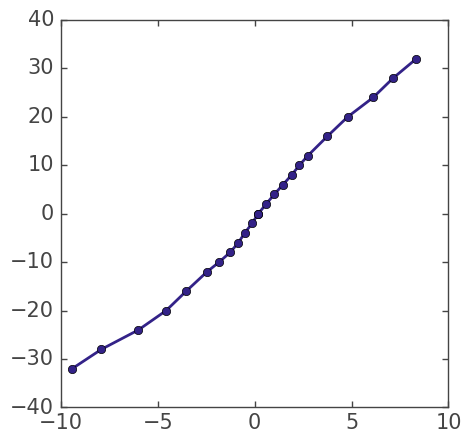

In [59]:
plt.plot(gromacs_data[:,0],gromacs_data[:,1],'o-')


      fun: 3.789796311289428
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -8.88178420e-08,   7.54951657e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 66
      nit: 17
   status: 0
  success: True
        x: array([ 23.02237581,   0.57962694])


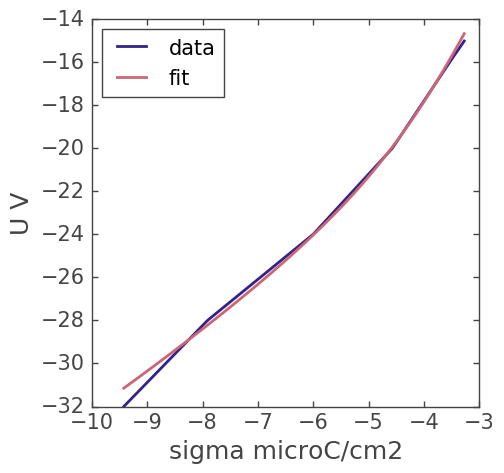

In [149]:
U0 = .25          # V
U_max_c =  -1.48911278e+01#-2.64117427e+01#
theta_max_c = 40#60#  # microC/cm^2
theta_max_a = -98  # microC/cm^2

def sigma_fit(u, theta_max, gamma, a0):
    exponential_term  = a0 + (1 - a0)*np.exp(-gamma*u**2)
    return np.r_[(theta_max*(-u)**(exponential_term))[u<0],-(theta_max*u**(exponential_term))[u>=0]]


def fit_c(x, sigma, U):
    """
    Cation fit objective function
    
    x : list
        Contains: U_max_c (V), gamma_c, a0_c
    """
    gamma_c, a0_c = x
    u = (U - U0)/U_max_c
    sigma_fit_c = sigma_fit(u, theta_max_c, gamma_c, a0_c)
    inv_dist_from_kappa = 1./(np.sqrt(np.abs(sigma_fit(u, theta_max_c, gamma_c, a0_c)+theta_max_c))+1)
    return np.sum(np.abs(sigma-sigma_fit_c)**(2)*inv_dist_from_kappa)
    #return np.sum(np.abs(sigma-sigma_fit_c)**(2))


# Define fit region
# sigma_c_fit = gromacs_data[:,1][gromacs_data[:,1] > 30]
# U_c_fit = gromacs_data[:,0][gromacs_data[:,1] > 30]
sigma_c_fit = chg_itp[chg_itp < -15]
U_c_fit = pot_itp[chg_itp < -15]


# initial guess
# gamma, a0
x0 = [30,.75]

res = sp.optimize.minimize(fit_c, x0, args=(sigma_c_fit, U_c_fit), bounds=[(0,100000), (0.5, 1)],
                          options={'ftol' : np.finfo(float).eps})
print res
x  = res.x
#x = x0

u = (U_c_fit-U0)/U_max_c
plt.plot(U_c_fit, sigma_c_fit,'-', label='data')
plt.plot(U_c_fit, sigma_fit(u, theta_max_c, x[0], x[1]), '-', label='fit')
#plt.plot(U_c_fit, sigma_fit(u, theta_max_c,  ), '--', label='fit05')

plt.xlabel('sigma microC/cm2')
plt.ylabel('U V')
plt.legend(loc='best')

      fun: 2.1049439259530027
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.00000000e+00,   4.44089210e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 174
      nit: 46
   status: 0
  success: True
        x: array([  1.17307687e+03,   8.66224631e-01])


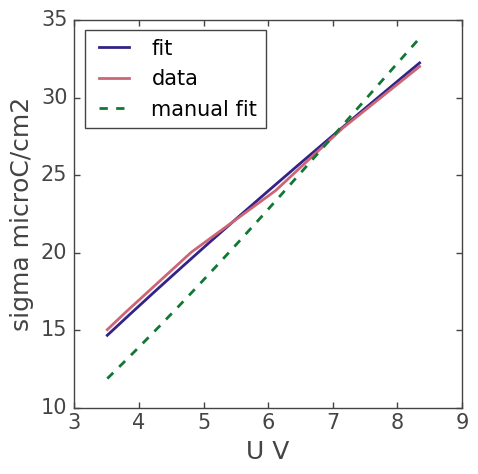

In [129]:
U0 = .25          # V
U_max_a =  2.92238593e+01
theta_max_a = -98  # microC/cm^2

def sigma_fit(u, theta_max, gamma, a0):
    exponential_term  = a0 + (1 - a0)*np.exp(-gamma*u**2)
    return np.r_[(theta_max*(-u)**(exponential_term))[u<0],-(theta_max*u**(exponential_term))[u>=0]]


def fit_a(x, sigma, U):
    """
    Cation fit objective function
    
    x : list
        Contains:  gamma_a, a0_a
    """
    gamma_a, a0_a = x
    u = (U - U0)/U_max_a
    sigma_fit_a = sigma_fit(u, theta_max_a, gamma_a, a0_a)
    inv_dist_from_kappa = 1./(np.sqrt(np.abs(sigma_fit(u, theta_max_a, gamma_a, a0_a)+theta_max_a))+1)
    return np.sum(np.abs(sigma-sigma_fit_a)**(2)*inv_dist_from_kappa)


# Define fit region
# sigma_c_fit = gromacs_data[:,1][gromacs_data[:,1] > 30]
# U_c_fit = gromacs_data[:,0][gromacs_data[:,1] > 30]
sigma_a_fit = chg_itp[chg_itp > 15]
U_a_fit = pot_itp[chg_itp > 15]


# initial guess
# gamma, a0
x0 = [ 2.01022641, 8.73793625e-01]

res = sp.optimize.minimize(fit_a, x0, args=(sigma_a_fit, U_a_fit), bounds=[(0,100000), (0.5, 1)],
                          options={'ftol' : np.finfo(float).eps})
print res
x  = res.x


u = (U_a_fit-U0)/U_max_a
plt.plot(U_a_fit, sigma_fit(u, theta_max_a, x[0], x[1]), '-', label='fit')
plt.plot(U_a_fit, sigma_a_fit,'-', label='data')
plt.plot(U_a_fit, sigma_fit(u, theta_max_a, 10, 0.68), '--', label='manual fit')

plt.ylabel('sigma microC/cm2')
plt.xlabel('U V')
plt.legend(loc='best')

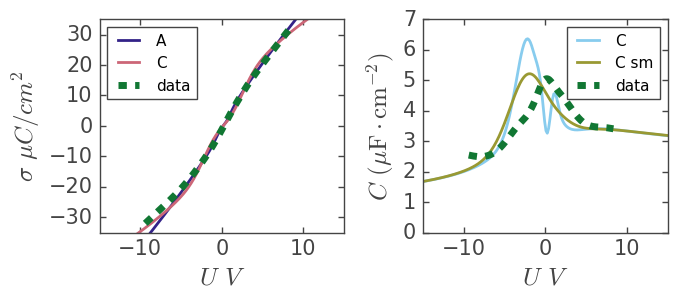

In [163]:
def sigma_fit(u, theta_max, gamma, a0):
    exponential_term  = a0 + (1 - a0)*np.exp(-gamma*u**2)
    return np.r_[(theta_max*(-u)**(exponential_term))[u<0],-(theta_max*u**(exponential_term))[u>=0]]

########## NPT values #################

# # data
U0 = .17          # V
U_max_a =  2.92238593e+01
U_max_c =  13.
theta_max_a = -98  # microC/cm^2
theta_max_c = 40#60#  # microC/cm^2

# fitted values
# gamma_c =  294.08625543
# a0_c = 0.61071358
gamma_c = 23.02237581
a0_c = 0.57962694
  
gamma_a = 1.17307687e+03
a0_a = 8.66224631e-01



########## NVT values #################

# data
# U0 = .17          # V
# U_max_a =  2.92238593e+01
# U_max_c =  1.48911278e+01#-2.64117427e+01#
# theta_max_a = -98  # microC/cm^2
# theta_max_c = 40#60#  # microC/cm^2

# # fitted values
# gamma_c = 1.6230877
# a0_c = 0.68479482
# gamma_a = 162.01022641
# a0_a = 0.71178643


# individual capacitances
#U_fit = np.linspace(-80, 40, num=1000)
U_fit, dU = np.linspace(-80, 80, num=1000, retstep=True)
u_a = (U_fit-U0)/U_max_a
u_c = (U_fit-U0)/U_max_c

sigma_a = sigma_fit(u_a, theta_max_a, gamma_a, a0_a)
sigma_c = -sigma_fit(u_c, theta_max_c, gamma_c, a0_c)
C_a = np.gradient(sigma_a, dU)
C_c = np.gradient(sigma_c, dU)

# combination of capacitances
gamma_ac = (max(gamma_c, gamma_a)/min(gamma_c, gamma_a))**(1./2)
C_h = 0.5*(C_a+C_c)+ 0.5*(np.tanh(gamma_ac*u_a)*C_a-np.tanh(gamma_ac*u_c)*C_c)

# smoothing
window = sp.signal.gaussian(400, 10)
# convolve the arrays
sC_h = sp.signal.convolve(C_h, window/window.sum(), mode='same')

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(7,3.25))

ax1.plot(U_fit, sigma_a, label='A')
ax1.plot(U_fit, sigma_c, label='C')
ax1.plot(chg_pot_cap[:,1],chg_pot_cap[:,0],'--',label='data',lw=5)
ax1.set_xlabel('$U$ $V$')
ax1.set_ylabel('$\sigma$ $\mu C/cm^2$')
ax1.legend(loc='best', fontsize=11)
ax1.locator_params(axis = 'x',nbins=5)
ax1.set_xlim(-15, 15)
ax1.set_ylim(-35,35)


#ax2.plot(U_fit, C_a, label='C-a',alpha=.3)
#ax2.plot(U_fit, C_c, label='C-c', alpha=.3)
ax2.plot(U_fit, C_h, label='C', color=color_wheel[3])
ax2.plot(U_fit, sC_h, label='C sm', color=color_wheel[5])
ax2.plot(chg_pot_cap[:,1],chg_pot_cap[:,2], '--',lw=5,  label='data',color=color_wheel[2])

ax2.set_xlim(-15, 15)
ax2.set_xlabel('$U$ $V$')
ax2.set_ylabel(r'$C$ $(\mathrm{\mu F\cdot cm^{-2}})$')
ax2.locator_params(axis = 'x',nbins=5)

ax2.legend(loc='best', fontsize=11)

fig.tight_layout()
#fig.savefig('../gfx/estimated_cap.png',dpi=300)

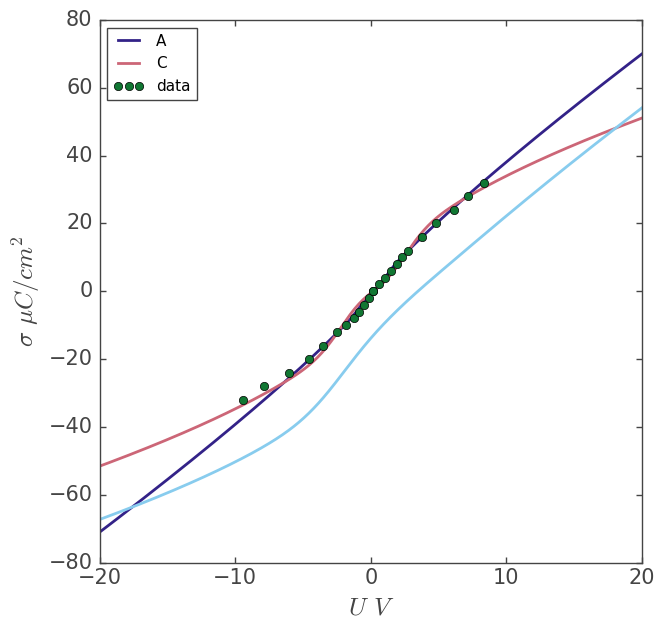

In [151]:
fig, (ax1) = plt.subplots(ncols=1,figsize=(7,7))

ax1.plot(U_fit, sigma_a, label='A')
ax1.plot(U_fit, sigma_c, label='C')
ax1.plot(gromacs_data[:,0],gromacs_data[:,1],'o',label='data',lw=5)
ax1.set_xlabel('$U$ $V$')
ax1.set_xlim(-20,20)
ax1.set_ylim(-80,80)
ax1.set_ylabel('$\sigma$ $\mu C/cm^2$')
ax1.legend(loc='best', fontsize=11)
ax1.locator_params(axis = 'x',nbins=5)

interp = sp.interpolate.InterpolatedUnivariateSpline(U_fit, sC_h, k=1)
x_interp = np.linspace(-20, 20, num=1000)
interp = interp.antiderivative()
sigma_s = interp(x_interp) 
ax1.plot(x_interp, sigma_s - 130)